# SMA Cross-over Strategy with Vectorised Backtesting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Load Data

In [2]:
raw_data = pd.read_csv("https://hilpisch.com/pyalgo_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna()
print(raw_data.head())

               AAPL.O  MSFT.O  INTC.O  AMZN.O    GS.N     SPY     .SPX   .VIX  \
Date                                                                            
2010-01-04  30.572827  30.950   20.88  133.90  173.08  113.33  1132.99  20.04   
2010-01-05  30.625684  30.960   20.87  134.69  176.14  113.63  1136.52  19.35   
2010-01-06  30.138541  30.770   20.80  132.25  174.26  113.71  1137.14  19.16   
2010-01-07  30.082827  30.452   20.60  130.00  177.67  114.19  1141.69  19.06   
2010-01-08  30.282827  30.660   20.83  133.52  174.31  114.57  1144.98  18.13   

              EUR=     XAU=    GDX     GLD  
Date                                        
2010-01-04  1.4411  1120.00  47.71  109.80  
2010-01-05  1.4368  1118.65  48.17  109.70  
2010-01-06  1.4412  1138.50  49.34  111.51  
2010-01-07  1.4318  1131.90  49.10  110.82  
2010-01-08  1.4412  1136.10  49.84  111.37  


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


### Select Desired Data to implement strategy and perform backtesting

In [4]:
instrument = 'EUR='
data = pd.DataFrame(raw_data[instrument])

In [5]:
data.rename(columns={instrument: 'Price'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


### Implementing Rolling SMA

In [6]:
SMA_1 = 52
SMA_2 = 272
SMA1 = f'SMA{SMA_1}'
SMA2 = f'SMA{SMA_2}'
data[SMA1] = data['Price'].rolling(SMA_1).mean()
data[SMA2] = data['Price'].rolling(SMA_2).mean()
data.tail()

,Price,SMA52,SMA272
Date,,,
2019-12-24,1.1087,1.108073,1.120808
2019-12-26,1.1096,1.108181,1.120723
2019-12-27,1.1175,1.108463,1.120682
2019-12-30,1.1197,1.108783,1.120619
2019-12-31,1.1210,1.109052,1.120553


<Axes: title={'center': 'EUR/USD with 52 and 272 Day SMAs'}, xlabel='Date'>

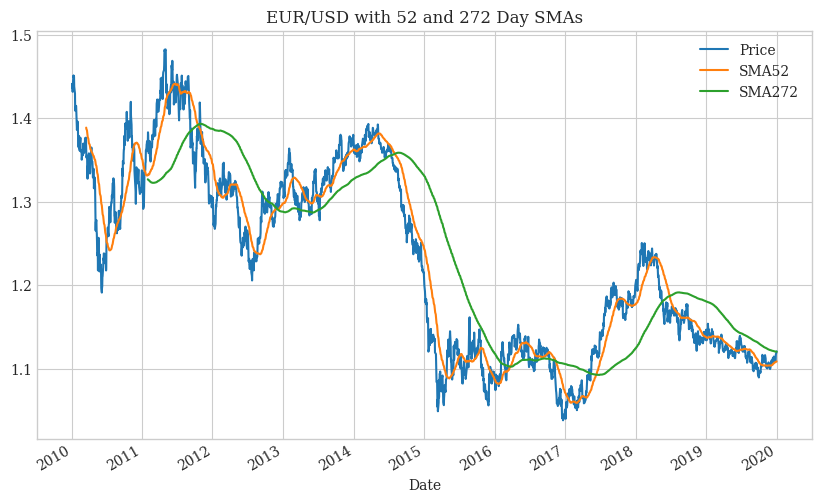

In [7]:
%matplotlib inline
from pylab import mpl, plt
# print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

data.plot(title=f'EUR/USD with {SMA_1} and {SMA_2} Day SMAs', figsize=(10, 6))

### Generating Trading Signals

<Axes: title={'center': 'Trading Position'}, xlabel='Date'>

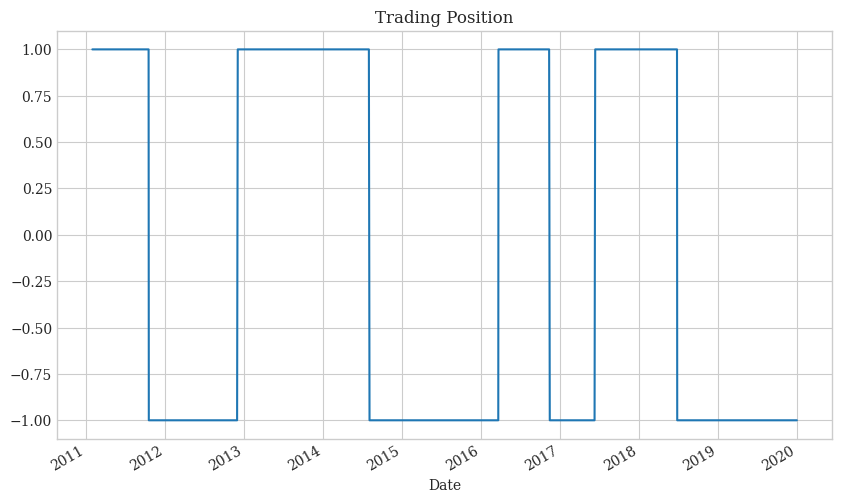

In [8]:
data['position'] = np.where(data[SMA1] > data[SMA2], 1, -1)
data.dropna(inplace=True)
data['position'].plot(ylim=[-1.1, 1.1], title='Trading Position', figsize=(10, 6))

### Calculating Daily Log Returns

<Axes: >

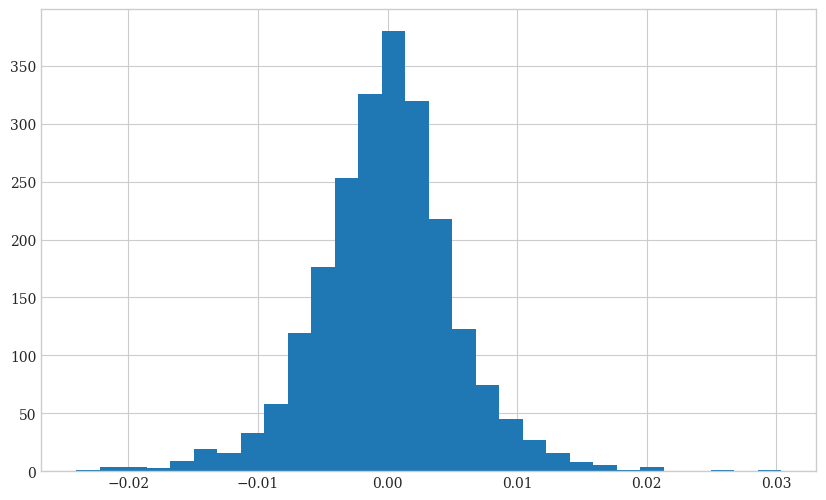

In [9]:
data['returns'] = np.log(data['Price'] / data['Price'].shift(1))
data['returns'].hist(bins=30, figsize=(10, 6))

In [10]:
data['returns'].tail()

Date
2019-12-24    0.000090
2019-12-26    0.000811
2019-12-27    0.007094
2019-12-30    0.001967
2019-12-31    0.001160
Name: returns, dtype: float64

### Strategy Returns based on Lagged Signal

In [11]:
data['sma_strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'sma_strategy']].sum()

returns        -0.199494
sma_strategy    0.255591
dtype: float64

In [12]:
# Compound Returns
data[['returns','sma_strategy']].sum().apply(np.exp)

returns         0.819145
sma_strategy    1.291224
dtype: float64

<Axes: title={'center': 'Cumulative Returns: Buy and Hold vs. SMA Strategy'}, xlabel='Date'>

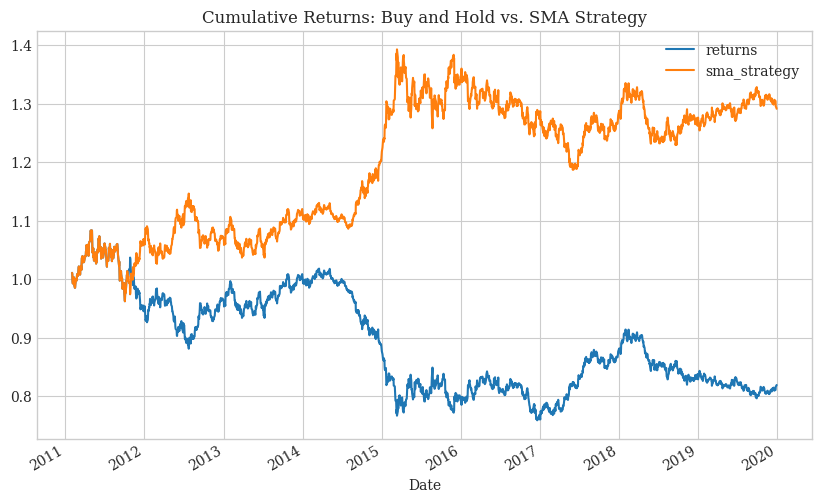

In [13]:
data[['returns','sma_strategy']].cumsum().apply(np.exp).plot(figsize=(10,6), title='Cumulative Returns: Buy and Hold vs. SMA Strategy')

In [14]:
# Log Annualized Mean Return
data[['returns', 'sma_strategy']].mean() * 252

# Regular Annualized Mean Return
np.exp(data[['returns', 'sma_strategy']].mean() * 252) - 1

returns        -0.022154
sma_strategy    0.029119
dtype: float64

In [15]:
# Log Annualized Standard Deviation
data[['returns', 'sma_strategy']].std() * 252 **0.5

# Regular Annualized Standard Deviation
(data[['returns', 'sma_strategy']].apply(np.exp) - 1).std() * 252 ** 0.5

returns         0.085108
sma_strategy    0.085084
dtype: float64

<Axes: title={'center': 'Cumulative Returns and Drawdown'}, xlabel='Date'>

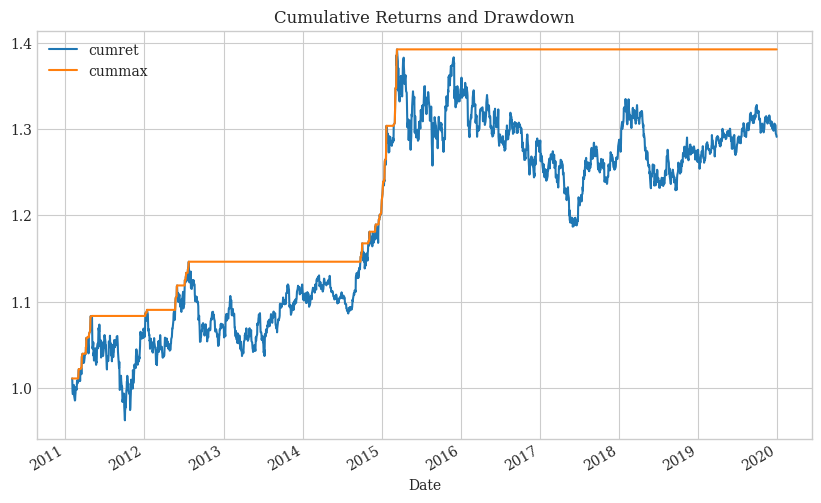

In [16]:
data['cumret'] = data['sma_strategy'].cumsum().apply(np.exp)
data['cummax'] = data['cumret'].cummax()

data[['cumret', 'cummax']].dropna().plot(figsize=(10,6), title='Cumulative Returns and Drawdown')

In [17]:
drawdown = data['cummax'] - data['cumret']
print(drawdown.max())

0.2057037438248408


In [18]:
temp_draw = drawdown[drawdown == 0]
periods = (temp_draw.index[1:].to_pydatetime() - temp_draw.index[:-1].to_pydatetime())
print(periods.max())

794 days, 0:00:00
